![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 24 - Time Series Analysis </center>
### <center> Auto-regressive </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/24_TimeSeries/MainAR.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

#### An auxiliary plot function to analyze the residuals $e_n$:

In [2]:
from scipy.stats                   import gaussian_kde, norm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic  import acorr_ljungbox

def PlotResidual(vEn, fig):
    std     = np.std        (vEn)
    oKde    = gaussian_kde  (vEn)
    _, pVal = acorr_ljungbox(vEn, [40], return_df=False) #-- white noise test
    pVal    = pVal[-1]

    #-- Plot error signal:
    x  = np.arange(len(vEn))
    ax = fig.add_subplot(2, 1, 1)
    ax.stem      (x, vEn, use_line_collection=True, label='$e_n$')
    ax.set_title (f'$\mu_e = {np.mean(vEn):.3f}$, $\sigma_e = {std:.3f}$')
    ax.set_xlabel('$n$')
    ax.set_xlim  (x[0], x[-1])
    plt.legend   ()

    #-- Plot historgram:
    xlim = (-3*std, 3*std)
    x    = np.linspace(xlim[0], xlim[1])
    ax   = fig.add_subplot(2,2,3)
    ax.hist     (vEn, density=True, color='c', edgecolor='k', label='Hist')
    ax.plot     (x, oKde(x),                                  label='KDE')
    ax.plot     (x, norm.pdf(x, 0, std),                      label='$\mathcal{N}(0,\sigma^2)$')
    ax.set_title('Density estimation')
    ax.set_xlim (xlim)
    ax.legend   ()
    
    #-- Plot auto-correlation function (ACF):
    ax = fig.add_subplot(2,2,4)
    plot_acf     (vEn, ax=ax, lags = 20, adjusted=True, label='$\hat{\\rho}_{e}[k]$')
    ax.set_title (f'white noise test: $p = {pVal:.5f}$')
    ax.set_xlabel('$k$')
    plt.legend   ()

    plt.tight_layout()

    return fig

#### Load the Lynx data:

In [3]:
dData = pd.read_csv('./Lynx.csv')
N     = len(dData)
dData

,Unnamed: 0,x
0,1,269
1,2,321
2,3,585
3,4,871
4,5,1475
...,...,...
109,110,662
110,111,1000
111,112,1590
112,113,2657


#### Plot the time series data $x_n$:

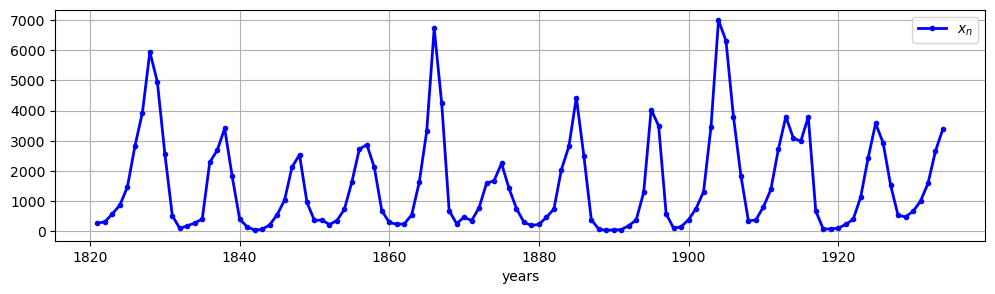

In [4]:
vTime = np.arange(1821, 1821 + N)
vXn   = dData.x.values

plt.figure(figsize=(12, 3))
plt.plot  (vTime, vXn, 'b', lw=2, marker='.', label='$x_n$')
plt.xlabel('years')
plt.grid  ()
plt.legend()
plt.show  ()

#### ACF and PACF plots:

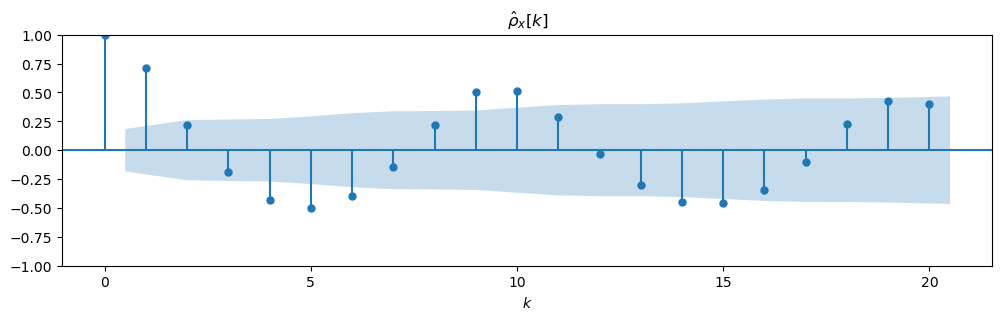

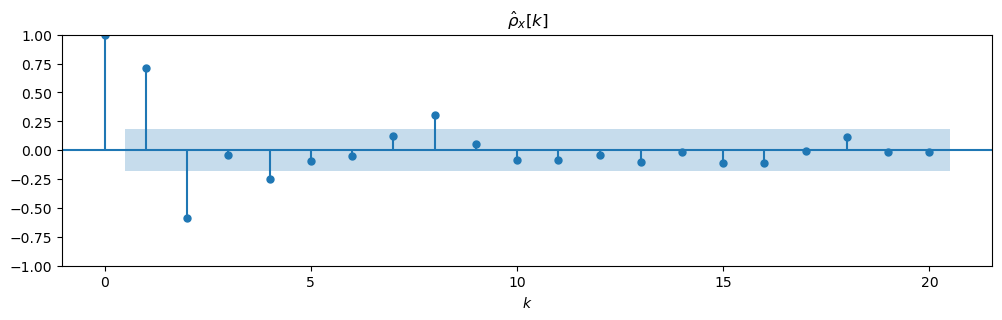

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_acf  (vXn, lags=20, ax=ax)
plt.title ('$\hat{\\rho}_x[k]$')
plt.xlabel('$k$')

_, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_pacf (vXn, lags=20, ax=ax, method='ywm')
plt.title ('$\hat{\\rho}_x[k]$')
plt.xlabel('$k$')
plt.show  ()

#### Naive estimation:
$$\hat{X}_{n}=X_{n-1}$$

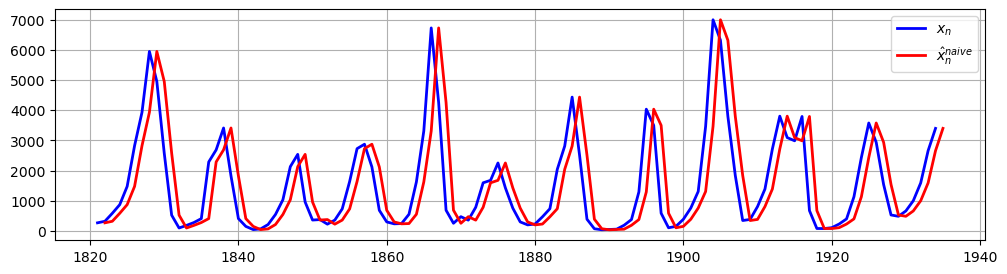

In [6]:
vNaiveX = vXn

plt.figure(figsize=(12,3))
plt.plot  (vTime,   vXn,     'b', lw=2, label='$x_n$')
plt.plot  (vTime+1, vNaiveX, 'r', lw=2, label='$\hat{x}_n^{naive}$')
plt.grid  ()
plt.legend()
plt.show  ()

#### Plot error (residual) statistics:
\begin{align*}
E_{n} & =X_{n}-\hat{X}_{n}\\
 & =X_{n}-X_{n-1}
\end{align*}

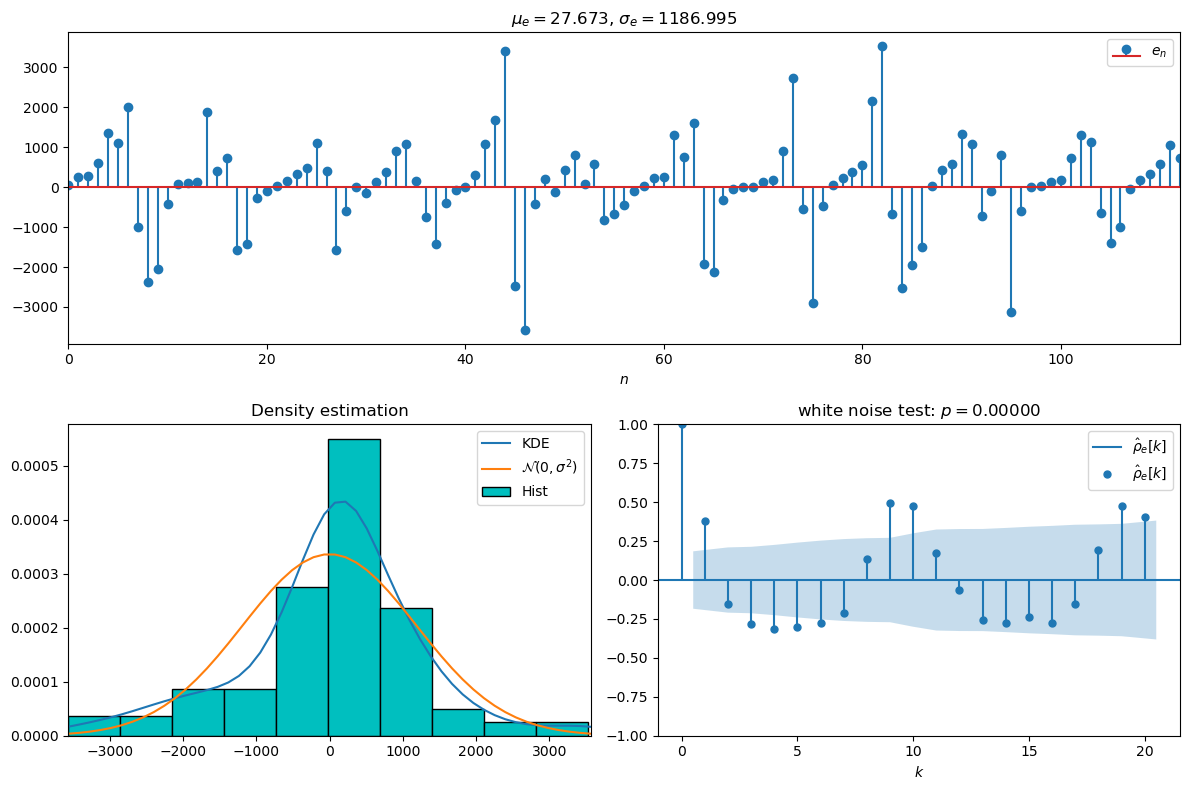

In [7]:
vEn = vXn[1:] - vNaiveX[:-1]

fig = plt.figure(figsize=(12, 8))
PlotResidual(vEn, fig)
plt.show    ()

Since $\left\{ e_{n}\right\} _{n}$ is not a white noise process ($\hat{\rho}_{e}$
does not seem like a delta function),  
we can improve our estimation.

### AR($p$) with $p=2$

In [8]:
from statsmodels.tsa.statespace import sarimax

p   = 2
oAR = sarimax.SARIMAX(vXn, order=(p,0,0), trend='c').fit()
oAR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -935.024
Date:                Tue, 02 Nov 2021   AIC                           1878.047
Time:                        15:28:10   BIC                           1888.992
Sample:                             0   HQIC                          1882.489
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    710.1055    195.862      3.626      0.000     326.224    1093.987
ar.L1          1.1454      0.064     17.833      0.000       1.020       1.271
ar.L2         -0.6015      0.085     -7.090      0.000      -0.768      -0.435
sigma2      7.767e+05   8.09e+04      9.600      0.000    6.18e+05    9.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                47.66
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.87
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

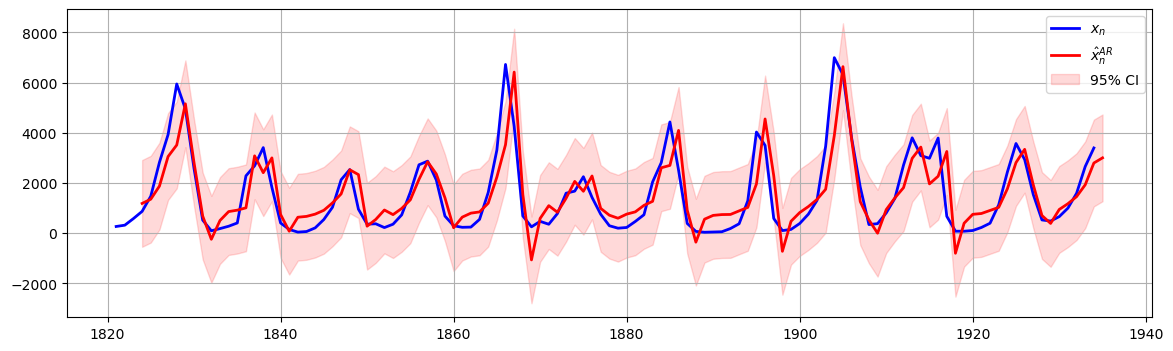

In [9]:
oPred  = oAR  .get_prediction(p+1, N, dynamic=False)
vHatXn = oPred.predicted_mean
mCI    = oPred.conf_int(alpha=0.05)

plt.figure      (figsize=(14, 4))
plt.fill_between(vTime[p:]+1, mCI[:,0], mCI[:,1], color='r', alpha=.15,   label = '95% CI')
plt.plot        (vTime,       vXn,    'b', lw=2, label='$x_n$')
plt.plot        (vTime[p:]+1, vHatXn, 'r', lw=2, label='$\hat{x}_n^{AR}$')
plt.grid        ()
plt.legend      ()
plt.show        ()

#### Plot error (residual) statistics:
\begin{align*}
E_{n} & =X_{n}-\hat{X}_{n}\\
 & =X_{n}-\left(c+a_{1}X_{n-1}+a_{2}X_{n-2}\right)
\end{align*}


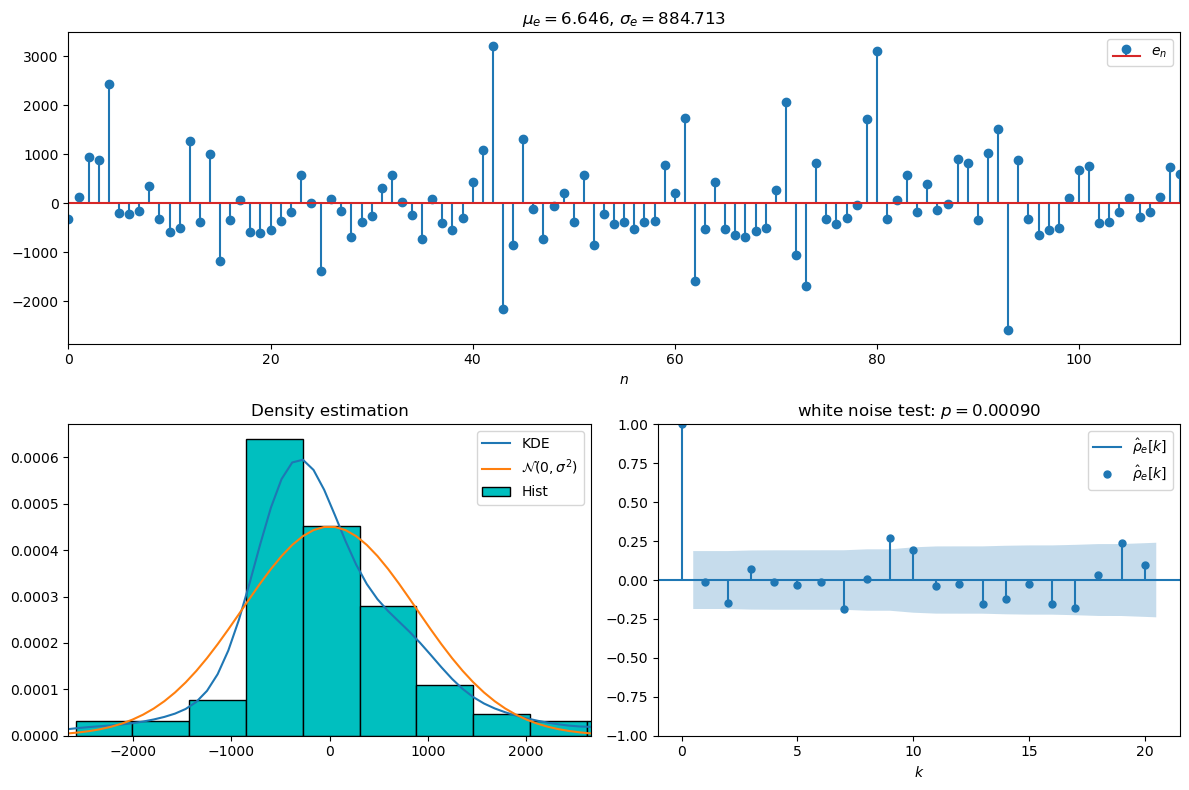

In [10]:
vEn = vXn[p+1:] - vHatXn[:-1]

fig = plt.figure(figsize=(12, 8))
PlotResidual    (vEn, fig)
plt.show        ()

### AR($p$):

In [11]:
def PlotAR(p):
    oAR    = sarimax.SARIMAX     (vXn, order=(p,0,0), trend='c').fit()
    oPred  = oAR  .get_prediction(p+1, N, dynamic=False)
    vHatXn = oPred.predicted_mean
    mCI    = oPred.conf_int       (alpha = 0.05)
    vEn    = vXn[p+1:] - vHatXn[:-1]
    
    plt.figure      (figsize=(12, 3))
    plt.fill_between(vTime[p:]+1, mCI[:,0], mCI[:,1], color='r', alpha=.15,   label = '95% CI')
    plt.plot        (vTime,       vXn,    'b', lw=2, label='$x_n$')
    plt.plot        (vTime[p:]+1, vHatXn, 'r', lw=2, label='$\hat{x}_n^{AR}$')
    plt.grid        ()
    plt.legend      ()

    fig = plt.figure(figsize=(12, 6))
    PlotResidual    (vEn, fig)

In [12]:
from ipywidgets   import interact, IntSlider, Layout

pSlider = IntSlider(min=0, max=30,  step=1, value=1, layout=Layout(width='80%'))
interact        (PlotAR, p=pSlider)
plt.tight_layout()
plt.show        ()

interactive(children=(IntSlider(value=1, description='p', layout=Layout(width='80%'), max=30), Output()), _dom…

<Figure size 640x480 with 0 Axes>